2024-08-23 17:27:42.946008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-23 17:27:47.813158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
782/782 [==============================] - 8192s 10s/step - loss: 1.1524 - val_loss: 0.0098
Epoch 2/10
782/782 [==============================] - 24978s 32s/step - loss: 0.0078 - val_loss: 0.0065
Epoch 3/10
782/782 [==============================] - 4467s 6s/step - loss: 0.0058 - val_loss: 0.0051
Epoch 4/10
782/782 [==============================] - 4457s 6s/step - loss: 0.0048 - val_loss: 0.0044
Epoch 5/10
782/782 [==============================] - 4468s 6s/step - loss: 0.0043 - val_loss: 0.0038
Epoch 6/10
782/782 [==============================] - 4475s 6s/step - loss: 0.0038 - val_loss: 0.0035
Epoch 7/10
782/782 [==============================] - 4464s 6s/step - loss: 0.0036 - val_loss: 0.0032
Epoch 8/10
782/782 [==============================] - 4468s 6s/step - loss: 0.0033 - val_loss: 0.0032
Epoch 9/10
782/782 [==============================] - 4476s 6s/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/10
1/1 [==============================] - 1s 651ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


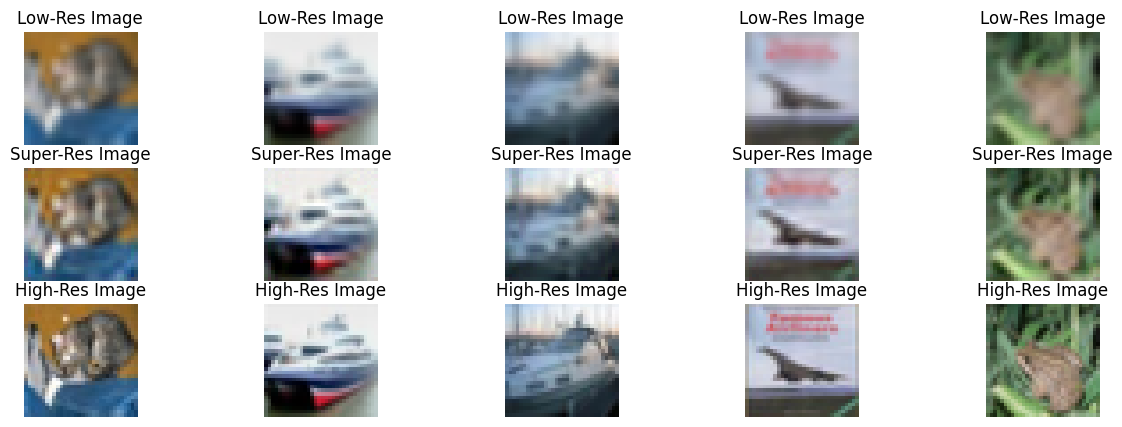

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Add, Input, UpSampling2D, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

# 殘差塊
def res_block(input_tensor, filters=64, kernel_size=3):
    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = Add()([x, input_tensor])  # 殘差連接
    return x

# 超分辨率模型
def build_resnet_sr_cnn(num_res_blocks=16):
    input_img = Input(shape=(32, 32, 3))

    x = Conv2D(64, (9, 9), padding='same')(input_img)
    x = LeakyReLU(alpha=0.2)(x)
    
    # 添加多個殘差塊
    for _ in range(num_res_blocks):
        x = res_block(x)

    # 上採樣層
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # 將輸出調整為32x32
    x = Conv2D(3, (3, 3), padding='same')(x)
    x = tf.keras.layers.experimental.preprocessing.Resizing(32, 32)(x)
    output_img = LeakyReLU(alpha=0.2)(x)

    model = Model(inputs=input_img, outputs=output_img)
    return model

# 加載 CIFAR10 資料集
(x_train, _), (x_test, _) = cifar10.load_data()

# 將影像標準化至 [0, 1] 之間
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 將影像縮小至 16x16 以模擬低分辨率影像
x_train_low_res = tf.image.resize(x_train, [16, 16])
x_test_low_res = tf.image.resize(x_test, [16, 16])

# 將低分辨率影像上採樣回 32x32
x_train_lr = tf.image.resize(x_train_low_res, [32, 32])
x_test_lr = tf.image.resize(x_test_low_res, [32, 32])

# 構建並編譯模型
resnet_sr_model = build_resnet_sr_cnn()
resnet_sr_model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
resnet_sr_model.fit(x_train_lr, x_train, epochs=10, batch_size=64, validation_data=(x_test_lr, x_test))

# 測試模型
test_img_lr = x_test_lr[0:5]
test_img_hr = x_test[0:5]
test_img_sr = resnet_sr_model.predict(test_img_lr)

# 展示結果
plt.figure(figsize=(15, 5))

for i in range(5):
    # 顯示低分辨率影像
    plt.subplot(3, 5, i + 1)
    plt.imshow(test_img_lr[i])
    plt.title("Low-Res Image")
    plt.axis("off")
    
    # 顯示超分辨率影像
    plt.subplot(3, 5, i + 6)
    plt.imshow(test_img_sr[i])
    plt.title("Super-Res Image")
    plt.axis("off")
    
    # 顯示高分辨率影像
    plt.subplot(3, 5, i + 11)
    plt.imshow(test_img_hr[i])
    plt.title("High-Res Image")
    plt.axis("off")

plt.show()


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Add, Input, UpSampling2D, LeakyReLU, BatchNormalization, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import DenseNet121
import numpy as np
import matplotlib.pyplot as plt

# 殘差塊
def res_block(input_tensor, filters=64, kernel_size=3):
    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, input_tensor])
    return x

# 生成器模型
def build_resnet_sr_cnn(num_res_blocks=32):
    input_img = Input(shape=(32, 32, 3))

    x = Conv2D(64, (9, 9), padding='same')(input_img)
    x = LeakyReLU(alpha=0.2)(x)

    # 添加多個殘差塊
    for _ in range(num_res_blocks):
        x = res_block(x)

    # 上採樣層
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    # 減少通道數以匹配DenseNet121的輸入要求
    x = Conv2D(3, (3, 3), padding='same')(x)
    
    # 使用預訓練DenseNet的特徵
    densenet = DenseNet121(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
    densenet.trainable = False
    x = densenet(x)

    # 將輸出調整為32x32
    x = Conv2D(3, (3, 3), padding='same')(x)
    x = tf.keras.layers.experimental.preprocessing.Resizing(32, 32)(x)
    output_img = LeakyReLU(alpha=0.2)(x)

    model = Model(inputs=input_img, outputs=output_img)
    return model

# 判別器模型
def build_discriminator():
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(64, (3, 3), strides=2, padding='same')(input_img)
    x = LeakyReLU(alpha=0.2)(x)

    for _ in range(3):
        x = Conv2D(64, (3, 3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_img, outputs=x)
    return model

# 加載 CIFAR10 資料集
(x_train, _), (x_test, _) = cifar10.load_data()

# 將影像標準化至 [0, 1] 之間
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 將影像縮小至 16x16 以模擬低分辨率影像
x_train_low_res = tf.image.resize(x_train, [16, 16])
x_test_low_res = tf.image.resize(x_test, [16, 16])

# 將低分辨率影像上採樣回 32x32
x_train_lr = tf.image.resize(x_train_low_res, [32, 32])
x_test_lr = tf.image.resize(x_test_low_res, [32, 32])

# 構建生成器和判別器模型
generator = build_resnet_sr_cnn()
discriminator = build_discriminator()

# 判別器優化器
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# 生成器優化器
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# 構建GAN模型
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

gan_input = Input(shape=(32, 32, 3))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)

gan = Model(gan_input, gan_output)
gan.compile(optimizer=generator_optimizer, loss='binary_crossentropy')

# 訓練GAN模型
epochs = 10000
batch_size = 64
for epoch in range(epochs):
    # 隨機選取真實影像
    idx = tf.convert_to_tensor(np.random.randint(0, x_train_lr.shape[0], batch_size), dtype=tf.int32)
    real_imgs = tf.gather(x_train, idx)
    
    # 生成影像
    noise = tf.gather(x_train_lr, idx)
    generated_imgs = generator.predict(noise)

    # 訓練判別器
    d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(generated_imgs, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # 訓練生成器
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 100 == 0:
        print(f"{epoch}: [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")

# 測試生成器
test_img_lr = x_test_lr[0:5]
test_img_hr = x_test[0:5]
test_img_sr = generator.predict(test_img_lr)

# 展示結果
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(3, 5, i + 1)
    plt.imshow(test_img_lr[i])
    plt.title("Low-Res Image")
    plt.axis("off")
    
    plt.subplot(3, 5, i + 6)
    plt.imshow(test_img_sr[i])
    plt.title("Super-Res Image")
    plt.axis("off")
    
    plt.subplot(3, 5, i + 11)
    plt.imshow(test_img_hr[i])
    plt.title("High-Res Image")
    plt.axis("off")

plt.show()


2/2 [==============================] - 5s 1s/step
0: [D loss: 0.7279147803783417, acc.: 57.03125] [G loss: 0.6221745014190674]
2/2 [==============================] - 4s 2s/step
100: [D loss: 0.4508008658885956, acc.: 95.3125] [G loss: 0.0012790923938155174]
1/2 [==============>...............] - ETA: 1s

KeyboardInterrupt: 